# Hands on - preprocessing with EEG data
### 1. Band-pass filtering(대역 통과 필터링)
- EEG 신호는 특정 주파수 범위(예: 1~40Hz)만을 통과시키고 그 외의 주파수 성분은 제거하는 전처리 단계
- 예를 들어, 뇌파의 저주파 잡음이나 고주파 노이즈(눈 깜빡임, 근육 움직임 등)를 줄이기 위해 사용

### 2. Data segmentation(데이터 세분화(분할))
- 연속적인 EEG 데이터를 자극 이벤트 기준으로 일정 시간 단위의 epoch으로 나누는 과정
- 예: 자극 시작 후 -200ms ~ 800ms 구간을 잘라 분석용 데이터로 사용

### 3. Singular value decomposition(SVD) and principal component analysis(PCA)(특이값 분해(SVD) 및 주성분 분석(PCA))
- 노이즈 제거, 차원 축소를 위해 사용
- EEG 데이터는 채널 수 x 시간 길이로 구성
- PCA는 이 데이터에서 분산이 큰 주요 성분을 추출해 분석 효율을 높임

### 4. Independent component analysis(ICA)(독립 성분 분석)
- EEG 데이터에서 눈 깜빡임, 심전도(ECG), 근전도(EMG)와 같은 잡음을 분리하는 데 사용
- ICA는 신호를 통계적으로 독립적인 성분들로 분해해, 노이즈 성분을 제거하고 뇌 신호만 남길 수 있음

#### EEG 데이터 전처리 및 분석에서 채널 선택과 분석 파라미터 설정을 정의한 부분

In [ ]:
# EEG의 1번부터 32번채널까지 선택
ch = 1:32; % select channels

# 구조체(struct) 생성: 분석 시 사용할 파라미터 저장
# freq: 대역통과 필터 범위 의미 / 1Hz ~ 40Hz 범위만 EEG 데이터에 남긴다는 뜻
# frame: 에포크 구간 / 자극극 이후 0~1000ms 구간을 분석에 사용
# baseline: 베이스라인 보정 구간 / 자극 전 -200ms ~ 0ms 구간 평균을 기준으로 신호 보정
# select_ch: 분석에 사용할 채널 인덱스 / 위에서 지정한 ch와 동일
# P300 speller 실험(ERP 기반 뇌-컴퓨터 인터페이스)에서 사용될 설정값들
Params_P3speller = struct('freq', [1 40], 'frame', [0 1000], ...
    'baseline', [-200 0], 'select_ch', 1:32);

# 정중선(midline) 전극 이름 목록
# FZ: 전두엽 중앙 / Cz: 중심 / Pz: 두정엽 중앙
electrodes_midline = {'FZ', 'Cz', 'Pz'};

# 눈 움직임 관련 자극
# 눈 깜빡임(눈 운동 아티팩트)을 감지하기 위해 자주 쓰이는 전극 위치
# FP1, FP2: 눈 바로 위쪽에 위치한 전두극 자극
# AF3, AF4: 눈썹 근처, 눈 주위 활동에 민감한 위치
# 이 전극들의 활동을 ICA로 분리해서 눈 움직임 잡음을 제거하는 데 사용
electrodes_eyes = {'FP1', 'FP2', 'AF3', 'AF4'};

#### P300 speller 데이터셋의 .mat 파일을 불러와서 각 실험 세션(test data)에서 데이터를 순회하려고 하는 구조

In [ ]:
# nsb는 subject 번호(또는 데이터 파일 번호)를 의미
# 원래는 1:55처럼 총 55명의 데이터를 반복 처리할 의도였지만, 지금은 테스트용으로 1만 처리하도록 고정해놓은 상태
for nsb=1 % :55
    fname_train = sprintf('../data/P300spellerdataset/s%02d.mat', nsb);
    EEG = load(fname_train);
    eeg_test = EEG.test; # 셀 배열, 각각의 원소가 한 번의 세션(run) 데이터를 의미
    
    eeg_nontarget = []; # non-target 자극(자극은 주어졌지만 사용자의 관심이 없던 자극) 데이터만 따로 추출해서 저장하려는 목적
    for nRun = length(eeg_test) % 1:length(eeg_test) # 원래는 1:length(eeg_test)로 작성해서 모든 실험 세션을 순회할 의도였으나, 지금은 1만 처리
        cur_eeg = eeg_test{nRun};
    end
end

#### EEG 1 trial 또는 1 run의 원시 데이터를 주파수 영역으로 시각화(spectrun polt) 하려는 것

In [ ]:
close all;

# cur_eeg는 1개의 실험 세션(run)에 대한 EEG 데이터 구조체
# 그 안의 data 필드는 [채널 x 시간] 형태의 행렬로 EEG 원시 신호가 저장되어 있음
# 예: 32 채널, 1000타임포인트 -> [32 x 1000]
data_untouched = cur_eeg.data; % [ch x time]

# EEG 신호의 샘플링 주파수(sampling rate) 의미
# 예: srate = 256이면, 초당 256개의 데이터 포인트가 있다는 뜻
srate = cur_eeg.srate; % sampling frequency 

# 채널 위치 정보가 담긴 구조체 배열
# 각 채널의 이름(.labels)과 3D 위치(x, y, z)가 저장되어 있음
# 나중에 scalp plot 그리거나 특정 채널을 식별할 때 필요
ch_locs = cur_eeg.chanlocs; % channel location and label info.

# spectopo: EEGLAB의 기본 함수, EEG 신호의 파워 스펙트럼을 시각화하는 함수
# data_untouched: 분석할 데이터 [ch x time]
# 0: 평균 길이(0이면 전체 데이터 사용)
# srate: 샘플링 주파수
# 각 채널별로 주파수 영역의 평균 파워(dB 단위)를 보여주는 그래프 출력
% Display data in frequency comain
figure,
spectopo(data_untouched, 0, srate);

# 주파수 축(x축)을 0Hz ~ 70Hz 범위로 제한해서 보기 좋게 조정
xlim([0, 70]);

[그래프 분석]
spectopo() 함수를 통해 각 EEG 채널의 주파수 영역 에너지 분포를 그린 파워 스펙트럼 플롯
- x축: Frequency(Hz)
    - 0Hz ~ 70Hz까지 주파수 범위
    - 각 주파수에 해당하는 EEG 신호의 에너지 밀도를 보여줌
- y축: Log Power Spectral Density
    - 전력 스펙트럼의 로그 스케일로, 신호 세기를 표현함
- 주요 관찰 포인트 
    - 60Hz 근처의 급격한 dips(감쇠)
        - 그래프에서 약 60Hz 부근에 강한 급락 현상
        - 이는 60Hz notch filtering(노치 필터링)이 적용되었거나,
        - 전원 노이즈에 대한 강한 제거 처리가 있었음을 시사
    - 8~13Hz(알파파) 영역에서 완만한 변화
        - 대부분의 채널에서 10Hz 전후로 약간의 peak 또는 plateau 존재
        - 이는 알파파(Alpha rhythm)의 흔적일 수 있음
        - 특히 눈 감은 상태에서 두정엽(Pz), 후두엽 채널에서 자주 나타남
    - 1~4Hz 구간의 높은 에너지
        - 0~5Hz 구간에서 전체적으로 에너지가 가장 큼
        - 이건 slow drift, EOG(눈 깜빡임) 등 저주파 노이즈 또는 생리적 활동 때문일 수 있음
        - ICA로 제거 대상이 될 가능성이 높음
    - 30~40Hz 이상 고주파 영역은 비교적 안정
        - 고주파 대역은 상대적으로 낮은 파워를 유지하고 있음
        - 이는 신호 자체가 적거나 필터링된 결과일 수 있음
        - 근전도(EMG) 아티팩트가 없다면 정상적인 패턴

[개념]
- 전원 노이즈(Power Line Noise)
    - 전기 설비나 전력 공급 장치로부터 발생하는 주기적인 고정 주파수의 전기적 간섭 신호
    - 우리가 사용하는 모든 전기 기기(조명, 컴퓨터, 모니터, 전원 코드 등)는 교류(AC) 전력을 사용
    - 이 AC 전력은 고정된 주파수로 진동:
        - 한국, 미국, 필리핀 등 -> 60Hz
        - 유럽, 중국, 일본(동부) 등 -> 50Hz
    - 즉, EEG 측정 중 주변 환경에 있는 AC 전기 시스템이 신호에 영향을 줘서 50/60Hz 주파수 성분이 EEG에 섞여 들어오는 것이 전원 노이즈
- 전원 노이즈가 EEG에 미치는 영향(EEG 분석에서 전원 노이즈가 문제인 이유)
    - 일정한 고주파 잡음으로 나타나 분석 방해
    - 분석 왜곡: 실제뇌파가 아닌데도 스펙트럼 파워가 높아져서 ERP나 뇌파 분석에 혼란을 줌
    - ICA 영향: ICA가 이 성분을 잡음으로 분리하지 못하면 다른 성분들과 섞임
    - 시각적 노이즈: EEG plot에서 파형이 진동처럼 보이고, 분석 정확도 저하
- 전원 노이즈 제거 방법
    - Notch filter(노치 필터)
        - 정확히 60Hz(또는 50Hz)를 차단하는 좁은 대역 필터
        - iirnoth() 또는 designfilt() 등으로 구현 가능
    - Band-stop filter
        - 좀 더 넓은 대역을 제거(예: 58~62Hz)
    - ICA
        - 독립 성분 중 전원 노이즈 성분이 뚜렷하면 제거 가능

#### EEG 데이터를 시간 영역(time domain)에서 시각적으로 확인하기 위한 명령어

In [ ]:
% Display data in time domain (scroll display)

# EEGLAB에서 제공하는 함수로, EEG 신호를 시간축에 따라 스크롤 가능한 창에서 시각화
# 각 채널의 신호를 아래로 나열해서 시간에 따라 변화하는 파형을 직접 확인 가능
# 보통 아티팩트 탐색(눈 깜빡임, 근육 잡음 등) 또는 수동 제거를 하기 전에 자주 사용
eegplot(data_untouched, 'srate', srate, 'winlength', 15, 'eloc_file', ch_locs);

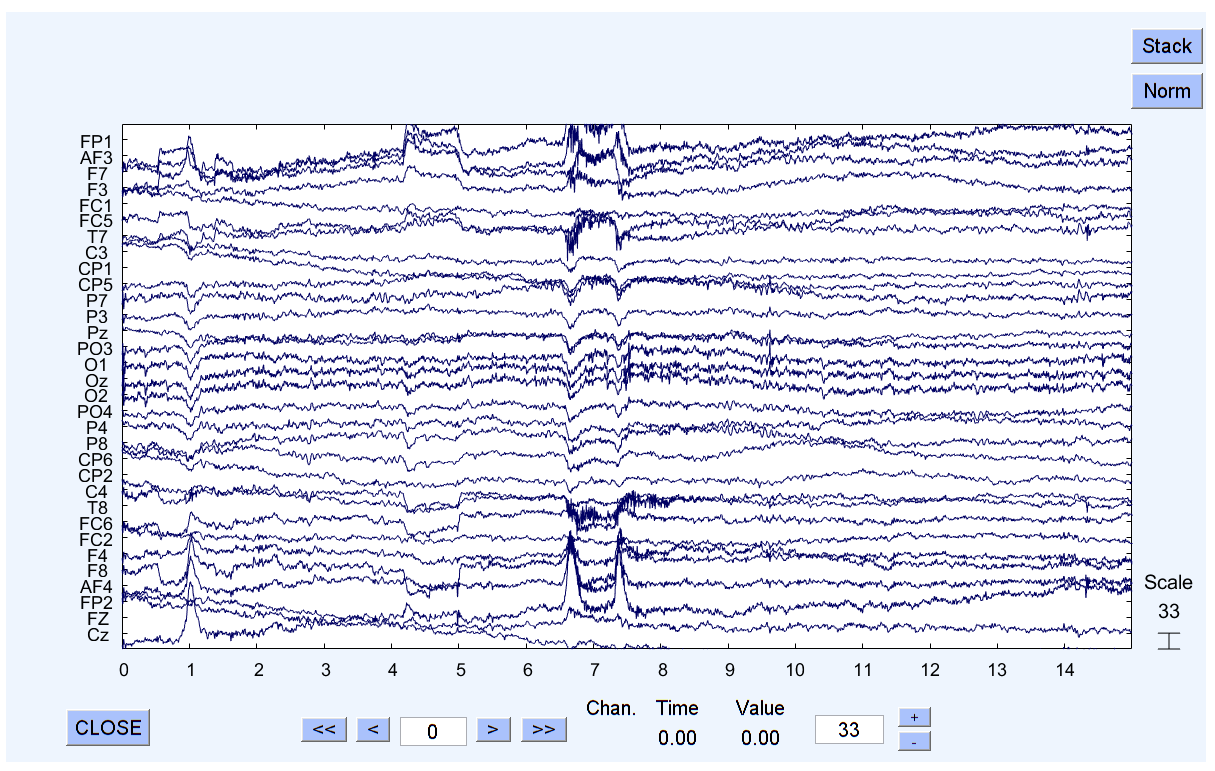

#### Extract noisy period (huge amplitude fluctuation): 잡음 주기 추출(엄청난 진폭 변동)
- EEG 신호에서 노이즈가 발생한 구간(80~100초 근처)을 잘라내서 시각적으로 확인하고, 시간/주파수 영역에서 동시에 분석

In [ ]:
# 앞서 eegplot()이나 다른 시각화 결과를 보고, 80~100초 부근에 큰 진폭 변화(잡음)가 있었던 걸 시각적으로 확인한 상태라는 가정
% We visually checked there is huge amplitude fluctuation around 80-100 s.

% Crop data containing the noise
# data_untouched는 [채널 x 시간 포인트] 형태의 원본 EEG 데이터
# 여기서 86~115초 구간을 잘라냄 -> 잘라낸 데이터가 data_nearby_artifacts에 저장됨
data_nearby_artifacts = data_untouched(:, 86*srate:115*srate);

# t는 시간 축 벡터
# 86초에서 115초까지 총 N개로 나눠진 벡터를 만들어줌
# 이걸 x축 시간으로 사용해서 시각화
t = linspace(86, 115, size(data_nearby_artifacts, 2));

% Check in butterfly plot (all channels on the x-axis)
# 시각화(두 개의 subplot)
figure,

# Butterfly plot: 모든 EEG 채널의 데이터를 겹쳐서 그린 그래프 ->  잡음이 있을 경우 진폭이 확 튀는 게 바로 보임
# 이걸 plot()에 넣으면 각 채널이 같은 시간축에 겹쳐 그려짐
subplot(1,2,1); plot(t, data_nearby_artifacts'); title('Butterfly plot');
xlabel('Time (s)'); ylabel('\muV'); 

# 잘라낸 noisy 구간에 대해 주파수 분석 수행
# spectopo()는 앞에서 설명했듯이 채널별 파워 스펙트럼을 시각화
# xlim([0, 70]): 70Hz 이하만 표시해서 전원 노이즈 제거 효과, 또는 관심 주파수 대역에 집중
subplot(1,2,2); spectopo(data_nearby_artifacts, 0, srate); xlim([0, 70]);

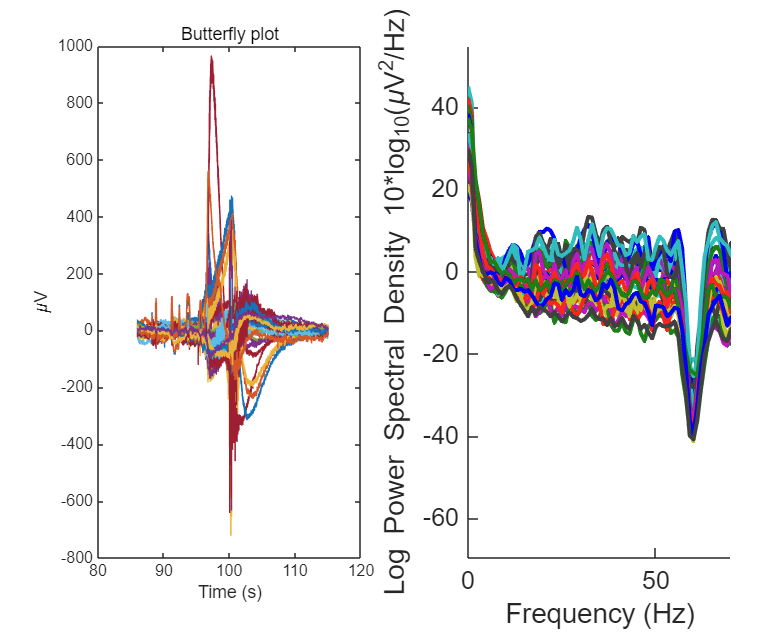

[그래프 분석] EEG 데이터 중 86~115초 구간에 대해 시각화한 결과
- 왼쪽: Butterfly plot(시간 영역)
    - 모든 채널의 EEG 신호를 시간축에 따라 겹쳐서 그린 그래프
    - X축: 시간(초) / Y축: EEG 진폭
    - 약 97초 근초에서 극단적인 진폭 변동 발생
        - 일부 채널은 +-800까지 튀어 오름
        - 이는 정상적인 뇌파 활동이 아니라 잡음(artifact)일 가능성이 높음
            - 예: 전극 접촉 불향, 움직임, 근육 노이즈, 기계적 간섭 등
        - 이 구간은 확실한 아티팩트이며, 전체 분석에 악영향을 줄 수 있음
        - ICA 수행 전에는 반드시 제거 또는 분리하는 것이 권장됨
- 오른쪽: Spectral plot(주파수 영역)
    - spectopo()로 얻은 전 채널 주파수별 평균 파워 스펙트럼
    - X축: 주파수(Hz) / Y축: 로그 파워
    - 0~5Hz에서 강한 파워 -> 저주파 잡음(눈 깜빡임, 움직임)
    - 60Hz 부근에서 sharp dip -> 노치 필터(전원 노이즈 제거 흔적)
    - 전반적으로 전체 채널에 고르지 않은 노이즈 패턴이 분포함
    - 아티팩트로 인해 전반적인 파워 분포가 왜곡됨
    - 특히 20~30Hz 대역에서 일부 채널의 power가 다른 채널에 비해 두드러짐

#### 앞에서 확인한 아티팩트(잡음)가 포함된 구간을 잘라내고, 그 결과가 어떻게 변했는지를 다시 시각화해서 확인
- 이제 큰 진폭 노이즈를 수동으로 배제하고 시간 및 주파수 영역에서 뇌파 데이터에 미치는 영향 확인
- 그러나 연속 데이터에서 수동으로 데이터를 잘라냈기 때문에 권장되지 않음

In [ ]:
# 아티팩트 구간 제거
# data_nearby_artifacts: 앞서 잘라낸 86~115초 EEG 데이터
# 그 중 9초~21초 구간 제거(여기서 이 9~21초는 data_nearby_artifacts 내부 기준 시간 -> 즉, 전체 EEG 시간 기준으로는 86+9 = 95초 ~ 86+21 = 107초 구간에 해당)
# 이 구간은 앞서 Butterfly plot에서 확인된 아티팩트가 있었던 바로 그 부분
# 이 줄은 해당 구간을 모든 채널에서 제거해서 분석에 영향을 주지 않도록 함
data_nearby_artifacts(:, 9*srate:21*srate) = []; % containing those artifacts

# 아티팩트 제거 후 시각화(제거한 후의 EEG 신호를 다시 그린 것)
# 시간 정보 없이 그냥 [ch x time] 데이터를 row로 나열한 형태의 plot
# ylim([-800 1000]): 이전 plot과 같은 Y축 스케일로 맞춰서 비교 가능하게 함
# 결과적으로, 이제는 진폭이 폭발하는 구간이 사라졌는지 확인 가능
figure,
subplot(1,2,1); plot(data_nearby_artifacts'); ylim([-800, 1000]); % same ylim as above
ylabel('\muV');

# 주파수 도메인 분석
# Y축은 로그 스펙트럼 파워 범위 -62 ~ +42dB -> 역시 앞서 그래프와 동일한 스케일을 유지해서 비교 쉽게 함
# X축은 0~70Hz까지만 시각화
# 이 plot에서 이전보다 전체 채널의 주파수 스펙트럼이 더 고르게 안정적으로 나타난다면, 아티팩트 제거가 효과 있었음을 보여주는 것
subplot(1,2,2); spectopo(data_nearby_artifacts, 0, srate); ylim([-62, 42]); xlim([0, 70]);

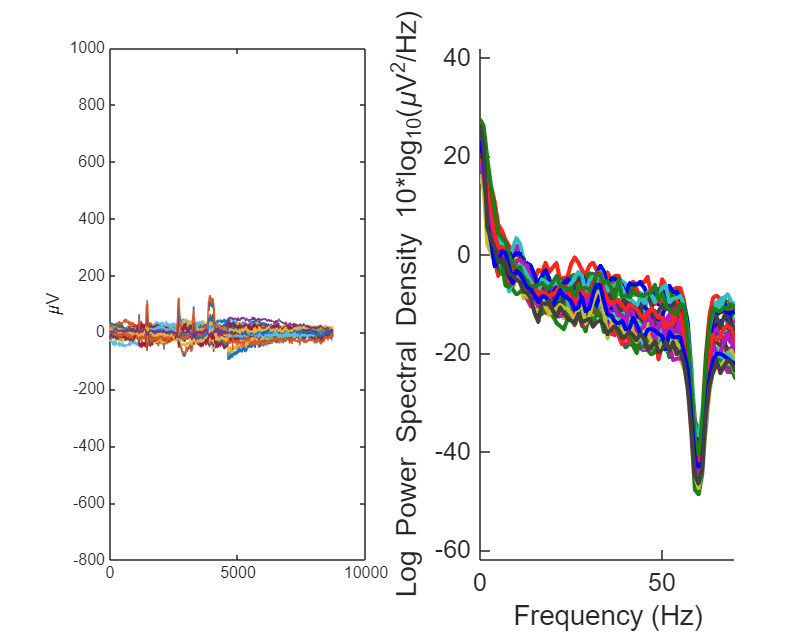

[그래프 분석] 아티팩트 구간(약 95초~107초)을 제거한 후의 EEG 시각화 결과
- 왼쪽: 시간 영역 플롯(Butterfly plot)
    - 모든 채널의 EEG를 시간순으로 겹쳐 그림
    - 이전 그래프에서는 97초 부근에서 +-800 이상 치솟던 아티팩트가 있었는데,
    - 현재 그래프에서는 대부분의 채널이 +-200 이내에서 안정적ㅇ니 신호를 보임
    - 심한 잡음이 사라짐
    - 제거 효과가 명확히 나타나며, 나머지 구간은 상대적으로 안정된 EEG 파형으로 구성
- 오른쪽: 주파수 영역 플롯(spectopo)
    - 각 채널의 파워 스펙트럼 밀도를 로그 스케일로 시각화
    - 0~5Hz 대역에서 파워는 여전히 상대적으로 크지만, 이전보다 안정적이고 낮아짐
    - 60Hz 부근에서 dip이 존재 -> 여전히 전원 노이즈 제거(노치 필터)의 흔적이 있음
    - 전반적으로 고주파수 영역(30~70Hz)의 노이즈가 줄어들었음
    - 아트팩트가 제거된 후, 전체 채널에서 주파수 분포가 더 균일하고 안정적으로 바뀜
    - 이는 ICA를 수행하기에도 좋은 상태라는 걸 보여즘

## Phase shift caused by causal filtering(인과 필터링으로 인한 위상 변화)
- causal 필터링은 위상 변화를 일으킬 수 있으며, 이는 필터링된 데이터에 위상 지연이 있음을 의미
- 인사이트에 영향
- 인과관계 FIR 저역 통과 필터를 사용한 테스트

#### 간단한 FIR(선형 위상) 저역통과 필터를 설계하고, 그 필터의 주파수 응답을 시각화하는 예제

In [ ]:
# Design Filter
% Simple filter design

# Fs는 샘플링 주파수(sampling rate)
# EEG 데이터에서 이미 정의된 srate 값을 그대로 사용
Fs = srate;

# 컷오프 주파수(cutoff frequency)를 30Hz로 지정
# 즉, 30Hz 이하의 주파수만 통과시키고 그 이상은 차단한느 저역통과 필터(Low-pass filter)를 만드려는 의도
fc = 30; % cutoff frequency

# 필터의 차수(order)
# FIR 필터의 차수가 클수록 전이 대역이 좁아지고 필터가 더 이상적으로 동작하지만, 연산량이 늘고 필터 지연이 커짐
order = 100;

# fir1 함수는 창 함수 기반 FIR 필터를 설계하는 MATLAB 내장 함수
# 두 번째 인자인 fc/(Fs/2)는 정규화된 컷오프 주파수 -> MATLAB의 필터 설계 함수는 나이퀴스트 주파수(=Fs/2) 기준으로 정규화된 값을 사용
# 반환되는 b는 FIR 필터의 계수(filter taps)
# 예: Fs = 256, fc = 30이면 -> fc/(Fs/2) = 30/128 = 0.234
# 이 값은 전체 주파수 대역 0~1 중 0.234 (즉, 23.4%)까지 통과시키겠다는 의미
b = fir1(order, fc/(Fs/2)); % FIR filter coefficients

# freqz(b, 1, Fs)는 필터의 주파수 응답(frequency response) 시각화
# b: 분자 계수(FIR 계수) / 1: 분모 계수(FIR은 IIR과 다르게 분모는 1) / Fs: x축을 Hz 단위로 보여주기 위해 샘플링 주파수 지정
figure,
freqz(b, 1, Fs); % filter property, s.t. frequency response

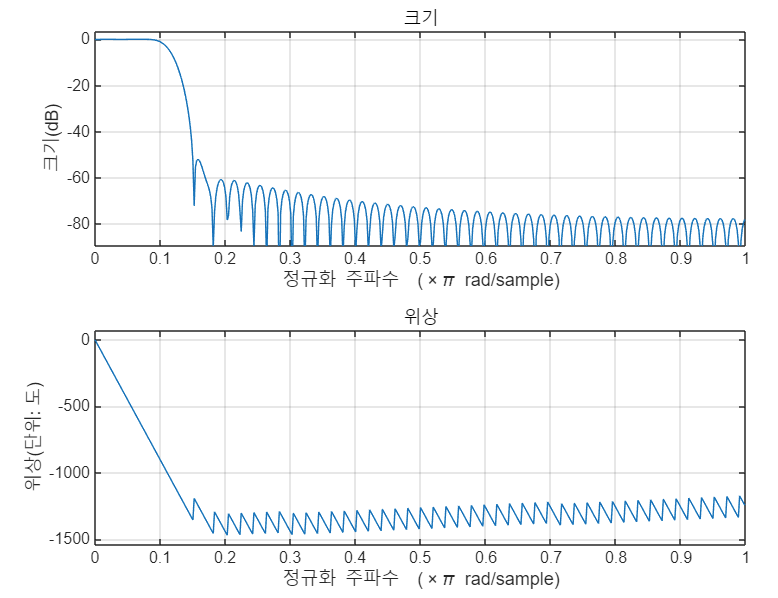

[그래프 분석] FIR 필터 설계 후 freqz() 함수로 출력된 주파수 응답 그래프
- FIR 필터가 EEG 전처리용 필터로 적합한 이유
    - 위상 왜곡이 없고 안정적이기 때문에 뇌파 데이터 전처리, 특히 ERP 분석에 매우 적합
    - muscle artifact 제거, 고주파 제거 등
- 위 그래프프: 크기 응답(Magnitude Response)
    - Y축: 크기(dB) - 각 주파수 성분이 얼마나 감쇠되는지(또는 유지되는지)
    - X축: 정규화 주파수(rad/sample) - 1은 나이퀴스트 주파수(= 샘플링 주파수의 절반)
    - 약 0.12 부근에서 급격한 감소 발생 -> 이 지점이 정규화된 컷오프 주파수
        - -> 실제 컷오프 주파수 = fc/(Fs/2) = 3Hz/(Fs/2)
        - 예: 샘플링 주파수 Fs = 256Hz일 경우
            - 컷오프 위치는 30/128 = 0.234
    - 이 컷오프 이전은 평탄하게 0dB 유지 -> 신호 그대로 통과
    - 이후 -40dB ~ -80dB로 급격히 감쇠 -> 잘 작동하는 저역통과 필터
    - 30Hz 이하 주파수 성분은 통과 / 30Hz 이상 고주파 성분은 강하게 억제
- 아래 그래프: 위상 응답(Phase Response)
    - Y축: 위상(단위: 도)
    - X축: 정규화 주파수
    - 위상이 직선 형태로 감소하고 있음 -> FIR 필터의 선형 위상(Linear Phase) 특성
    - EEG 같은 생체 신호에서는 위상 왜곡이 중요한데, 이 필터는 위상 왜곡이 없음 -> 즉, 파형의 모양이 보존됨
    

#### Applying causal filter: 직접 설계한 FIR 필터를 EEG 데이터에 적용하고, 필터링 전후 신호를 한눈에 비교할 수 있도록 eegplot() 활용

In [2]:
# Applying causal filter

# filter(b, 1, x) 함수
# b: FIR 필터 계수(앞서 fir1()으로 만든 저역통과 필터)
# 1: 분포 계수(a=1 -> FIR 필터라는 뜻)
# x: 입력 신호, 여기서는 data_untouched'

# 왜 전치(')했을까?
#  data_untouched는 [channel x time] 구조
#  filter()는 각 열을 독립적인 신호로 처리하므로, 전치시켜서 [time x channel]로 만든 다음, 채널별로 시간에 따라 필터링 적용 


# 필터가 적용된 데이터 eeg_shifted는 [time x channel]이므로 다시 전치해서 [channel x time]으로 원래 형태로 복구
eeg_shifted = filter(b, 1, data_untouched');  % Apply causal filter'


# eegplot 비교 모드
# data_untouched: 원본 EEG 데이터
# 'data2', eeg_shifted': 필터가 적용된 EEG 데이터(전치해서 형상 맞춤)
# 'srate': 샘플링 주파수
# 'eloc_file': 채널 이름 및 위치 정보

# eegplot 창에서 원본 신호와 필터링된 신호를 동시에 비교 가능
# 필터링된 결과가 더 부드럽고 고주파 노이즈가 줄어든 형태로 나타날 것
# 원본과 비교하면서 필터링이 얼마나 효과적인지 시각적으로 판단 가능
eegplot(data_untouched, 'data2', eeg_shifted', 'srate', cur_eeg.srate, 'eloc_file', cur_eeg.chanlocs);

SyntaxError: unterminated string literal (detected at line 26) (4248371331.py, line 26)

[그래프 분석] eegplot() 함수로 시각화한 EEG 필터링 전후 신호 비교 화면
- 파란색은 원본 신호, 빨간색은 필터링된 신호
- Y축: 채널 이름 (FP1, AF3, F7, ... Cz)
    - 총 32~64개 채널이 나열되어 있음
- X축: 시간 (초 단위)
- 신호 색상
    - 파란색: 원본 EEG (data_untouched)
    - 빨간색: 필터링된 EEG (eeg_shifted)
- 분석: 필터 전후 차이점
    - 전반적인 결과
        - 전체적으로 빨간색 필터링 신호가 더 부드럽고노이즈가 억제된 걸 볼 수 있음
        - 특히 고주파 성분(빠르게 진동하는 긋한 요동)은 눈에 띄게 줄어듦
    - 채널별 관찰 포인트 예시
        - FP1, FP2, AF3, AF4 (눈 근처 채널)
            - 눈 깜빡임 등 저주파 아티팩트가 있을 수 있음
            - 여전히 일부 느린 파형이 존재하지만 고주파는 줄어든 상태
    - FC, CP, T 채널들
        - 전반적으로 고주파 잡음 감소 효과 뚜렷
        - 예: FC2, T7 같은 채널에서는 필터 전 신호에 미세한 톱니 같은 진동이 있었는데, 필터 후에 거의 사라짐
    - O1, O2, PO4, Pz
        - 후두부/두정엽 부위 → ERP 분석(P300 등)에서 중요한 위치
        - 여기는 기본적으로 상대적으로 노이즈가 적은 편이었고, 필터 적용 후에도 안정적인 형태 유지

- 이제 파란색 선과 빨간색 선 사이에 위상 변화가 있다는 것을 알 수 있다. 파란색 선은 필터링 전 뇌파를 나타내고 빨간색 선은 필터링된 데이터를 나타낸다.

[추가 정리]
- 필터링 목적: 30Hz 이상 고주파 노이즈 제거(FIR low-pass)
- 시각적 차이: 빨간색(필터 후) 신호가 더 부드럽고 진동이 적음
- 효과: 근육 노이즈, 전원 노이즈, 기타 고주파 간석 신호 억제
- 위상 보존: FIR 필터라서 파형의 위상 왜곡 없음(형태 유지)

#### Applying zero-phase filter: FIR 필터를 지연 없이(위상 왜곡 없이) 적용하기 위해 filtfilt() 함수를 사용해서 zero-phase filtering을 수행하고, 원본 EEG 신호와 필터링된 신호를 시각적으로 비교

[eeg_zero_phase_filtered = filtfilt(b, 1, data_untouched');  % Apply causal filter]

filtfilt() 함수란?
- 양방향 필터링 (forward + reverse)
- 순방향으로 한 번, 역방향으로 한 번 필터링을 적용
- 결과적으로 위상 지연(phase delay)이 0이 됨
- FIR 필터 사용 시 선형 위상 + zero-phase -> 파형이 왜곡되지 않음

filter()와 차이
- filter(): 위상 지연 있음(지연 발생) / 사용 목적: 실시간 필터링(Causal)
- filtfilt(): 위상 지연 없음(Zero-phase) / 사용 목적: 신호 파형 보전(ERP 분석에 최적)

전치 이유
- data_untouched는 [channel x time] 구조
- filtfilt()는 행 단위 = 채널별로 시간 방향 필터링하므로 data_untouched'로 전치 -> [time x channel]
- 결과값도 전치해서 다시 [channel x time]로 복원

In [ ]:
# Applying zero-phase filter

eeg_zero_phase_filtered = filtfilt(b, 1, data_untouched');  % Apply causal filter

# EEG 플롯 창에 원본 신호(파란색)과 필터링된 신호(빨간색)를 같은 창에서 동시에 비교 가능
# data2: 두 번째 데이터(비교용)로 쓰임
# srate: 샘플링 주파수
# eloc_file: 채널 위치와 이름 정보
eegplot(data_untouched, 'data2', eeg_zero_phase_filtered', ...
    'srate', cur_eeg.srate, 'eloc_file', cur_eeg.chanlocs);

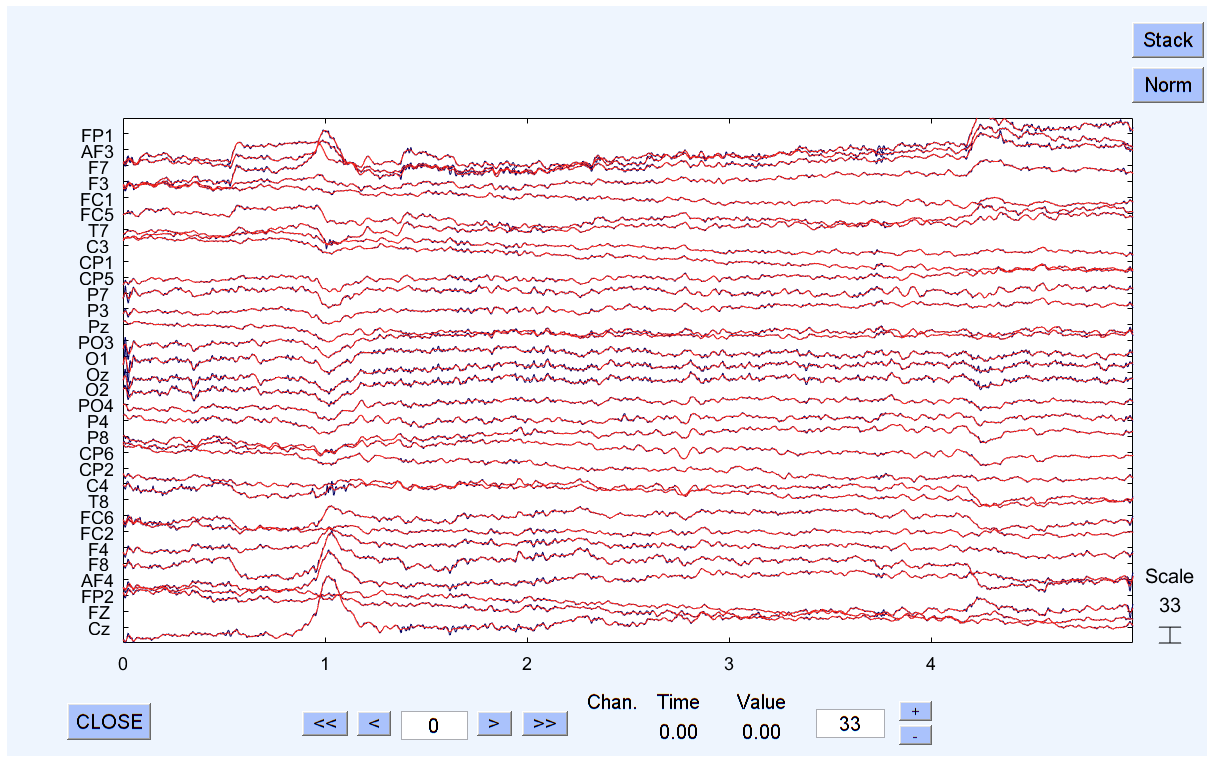

[그래프 분석]: eegplot()으로 zero-phase 필터링 후 EEG 신호와 원본 신호를 비교한 결과
- 이전 그래프와 비교해보면 신호 왜곡 없이 부드럽게 정제된 뇌파 신호가 잘 나타나는 것을 확인 가능
- 파란색: 필터 전 원본 EEG 신호
- 빨간색: FIR 저역통과 필터(filtfilt)를 사용한 zero-phase 필터링 결과
- 1. 고주파 잡음 감소(고주파 노이즈 제거): 매우 효과적, 전체 채널에 걸쳐 고주파 진동 감소
    - 대부분의 채널에서 빨간색(필터 후) 신호가 더 부드럽고 매끄럽게 변화
    - 특히 전두부 채널(FP1, FP2, AF3, AF4 등)에서 빠른 진동 성분 감소
    - 이는 근전도(EMG)나 전원 노이즈 성분이 잘 억제된 것으로 보임
- 2. 위상 보존: 신호 모양 유지됨 -> ERP 분석에 적합
    - 빨간색 신호가 파란색과 거의 겹쳐 있음
    - 시간축 상에서 밀림이 없고, 파형의 모양도 유지됨
    - 이게 바로 filtfilt()의 장점: 위상 왜곡 없이 필터링
- 3. 눈 깜빡임 등의 저주파 성분은 일부 남아 있음: 눈 움직임(EOG), 근전도(EMG) 일부 존재 가능
    - AF4, FP2, FP1 등에서 큰 진폭의 느린 파형 존재
    - -> 이건 주로 EOG(눈 움직임) 성분이므로, ICA로 분리 제거해야 함
- 역방향 및 전방 필터링을 적용하면 위상 변화를 피할 수 있다.

### Data segmentation: 데이터 세분화
- 연속적인 2차원 EEG 데이터에서 이벤트 마커(event markers)를 사용하면, 관심 있는 EEG 데이터만 잘라낸 세분화된(epoch 형태의) 데이터를 얻을 수 있음
- 이를 통해 클래스별 EEG 데이터나 특정 조건에 해당하는 데이터만 추출 가능
- 이 데이터셋에서는 이벤트 마커 값이 0, 1, 2 중 하나로 주어지며:
    - 0: 이벤트 없음(기본 상태)
    - 1: 타켓 이벤트(Target event)
    - 2: 논타켓 이벤트(Non-target event)

#### EEG 데이터에 포함된 이벤트 마커(event markers)를 확인하기 위한 간단한 분석 코드

In [ ]:
# cur_eeg는 현재 사용 중인 EEG 데이터 구조체(1개의 run or session)
# 그 안에 포함된 필드 중 markers_target은 이벤트 마커 배열
# 즉, 이 EEG 세션에서 자극(이벤트)이 언제 어떤 종류로 발생했는지를 나타내는 벡터
event_markers = cur_eeg.markers_target;

# unique()함수는 event_markers 안에 존재하는 고유한 값들만 추출
# disp(...)는 그 결과를 출력함
# unique(event_markers)를 출력하면, 예를 들어 [0 1 2]가 나올 수 있고, 이는 해당 세션에 3종류 마커가 모두 존재한다는 의미
disp(unique(event_markers));

#### event_markers 벡터를 이용해서 타겟과 논타겟 이벤트를 각각 분리하는 작업
- 타겟과 논타켓을 이진 벡터(binary vector) 형태로 따로 분리해서 각각의 epoch을 만들기 위한 전처리 작업

In [ ]:
# 1. 타겟 이벤트 추출
# event_markers에서 논타겟(2)은 모두 제거하고, 타겟(1)은 그대로 유지
# 나머지(0, 즉 이벤트 없음)는 그대로 두되 타겟만 남기는 구조
# 결과적으로 tmp_target은 타겟 위치에는 1, 그 외 위치에는 0인 벡터가 됨
% Extract target event markers
tmp_target = event_markers;
tmp_target(tmp_target==2) = 0; % remove non-target event_markers
% tmp_target: 1 for target o/w 0

# 2. 논타겟 이벤트 추출
# 타겟(1)을 제거하고, 논타겟(2)와 나머지를 유지
# sign() 함수는 입력 값이: 0->0, 양수(2)->1
# 따라서 논타겟 위치에만 1, 그 외는 0이 됨
# 최종적으로 tmp_nontarget은 논타겟만 1로 표시된 이진 벡터
% Extract non-target event markers
tmp_nontarget = event_markers;
tmp_nontarget(tmp_nontarget==1) = 0; % remove target merkers
tmp_nontarget = sign(tmp_nontarget);
% tmp_nontarget: 1 for nontarget o/w 0

#### EEG 데이터를 대역통과 필터(bandpass filter)로 정제하면서, 필터 적용 전 평균값 제거(demeaning)도 함께 수행
- EEG 데이터에서 지정된 주파수 범위(예: 1~40Hz)만 통과시키는 Butterworth 대역통과 필터를 적용하여 분석에 불필요한 저주파 및 고주파 잡음을 제거하는 과정

In [ ]:
# 버터워스 IIR 필터를 사용하여 추가 대역 통과 필터링 적용 (4차)

# 1. 대역통과 필터 주파수 설정
# Params_P3speller.freq: 예를 들어 [1 40] -> 통과 대역 1Hz ~ 40Hz
# srate: 샘플링 주파수(예: 256Hz, 512Hz 등)
# Butterworth 필터 설계 시, 주파수를 나이퀴스트 주파수(Fs/2) 기준으로 정규화해야 하므로 /(srate/2)를 사용용
wn = Params_P3speller.freq / (srate/2);
# 예:
#   srate = 256;
#   Params_P3speller.freq = [1 40];
#   wn = [1 40] / 128 = [0.0078 0.3125]


# 2. Butterworth 필터 계수 계산산
# 차수(order) 4의 Butterworth 대역통과 필터를 설계
# b, a: 필터의 분자, 분모 계수
# Butterworth 필터 특징:
#   응답이 부드럽고, 통과 대역에서 flat
#   ERP/EEG 전처리에 자주 사용됨
[b, a] = butter(4, wn, 'bandpass');

# 3. 데이터 평균값 제거(demeaning)
% demean the data before filtering
meandat = mean(data_untouched, 2); # 각 채널의 평균값 계산(행 단위로로)
data_untouched = bsxfun(@minus, data_untouched, meandat); # bsxfun(...): 각 채널의 평균값을 전체 시계열에서 빼기 -> demeaning
# -> 왜 필요할까?
#   EEG 신호는 DC 오프셋(평균 전압)이 있을 수 있고, 필터링 전에 이를 제거해주면 안정된 결과를 얻을 수 있음

# 4. 필터 적용
# filtfilt: 양방향 필터링 -> 위상 지연 없음
# data_untouched': [channel x time] -> [time x channel]로 전치
# filtfilt는 시간축을 기준으로 동작하므로 전치가 필요함
# 결과는 다시 전치해서 원래대로 [channel x time]
filt_eeg = filtfilt(b, a, data_untouched')';

#### 필터링된 EEG 데이터에서 이벤트 마커를 기준으로 epoch을 잘라내는 함수 정의 및 target과 non-target EEG epoch를 분리하는 작업
- 연속적인 EEG 데이터(filt_eeg)에서 자극 시점(event marker)을 기준으로 특정 시간 구간(epoch)만 잘라서 3차원 배열 [채널 × 시간 × trial]로 만드는 작업

In [ ]:
# 이벤트 마커를 기반으로 2D 데이터를 3D 데이터로 변환 [ch x 시간 x 시도]

# 1. epoch 추출 함수 사용
# filt_eeg: 필터링된 EEG 데이터 [채널 x 시간]
# srate: 샘플링 주파수 (예: 256Hz)
# tmp_target: 타겟 이벤트가 표시된 이진 벡터(1이면 자극 발생, 0이면 없음)
# Params_P3speller.frame: 잘라낼 epoch 시간 범위(예: [0 1000] -> 자극 후 0~1000ms)
epoch_target = eeg_extract_epochs(filt_eeg, srate, tmp_target, Params_P3speller.frame);

# 함수 정의
# data2D: EEG 데이터 [채널 x 시간]
# event_markers: 자극 발생 위치가 1로 표시된 벡터
# frame: epoch 범위([시작(ms), 종료(ms), 예: [0 1000]])
# 반환값 out: [채널 x 시간 포인트 x trial] 형태의 3차원 배열
function out = eeg_extract_epochs(data2D, srate, event_markers, frame)

out = [];

# for 루프
ind = find(event_markers > 0); # 이벤트가 발생한 인덱스만 추출

# 각 이벤트 발생 시점을 기준으로, frame 범위만큼 EEG 데이터를 잘라서 out에 쌓음
# cat(3, ...)은 3차원으로 붙이기 -> trail마다 세 번째 차원으로 쌓임
# 예: 32채널 EEG에서, [0, 1000]ms 구간을 256Hz로 샘플링했다면 한 epoch은 [32 x 256], 이를 trial 수 만큼 -> [32 x 256 x N] 형태가 됨
for nTrials=1:length(ind)
    begin_frame = ind(nTrials) + floor(frame(1)/1000*srate);
    end_frame = ind(nTrials) + floor(frame(2)/1000*srate)-1;
    out = cat(3, out, data2D(:, begin_frame:end_frame));
end

# 위와 동일한 방식으로, non-target 이벤트만 골리서 epoch 생성
end
epoch_nontarget = eeg_extract_epochs(filt_eeg, srate, tmp_nontarget, Params_P3speller.frame);

# disp()로 shape 확인
disp('Target epochs [ch x time x samples]');
disp(size(epoch_target));

disp('Nontarget epochs [ch x time x samples');
disp(size((epoch_nontarget)));

# epoch_target: 3차원 EEG 데이터 [ch × time × trial]
# eegplot()은 2D 입력만 받기 때문에 -> 내부적으로 trial들을 시간축으로 이어붙임
# 즉, 각 epoch을 순서대로 나열한 "연속된 데이터처럼 보이는 그림"을 출력함
eegplot(epoch_target, 'srate', srate, 'eloc_file', ch_locs, 'title', 'target', 'winlength', 13);

[그래프 분석]: epoch_target은 타겟 자극 발생 후 잘라낸 EEG 세그먼트들 의미
- 크기: [채널 x 시간 포인트 x trial 수]
- eegplot()은 이 3차원 데이터를 trial 단위로 시간축에 이어붙여서 시각화해줌
- 따라서, 이 플롯은 각 trial이 연속적으로 나열된 것처럼 보이는 형태
- 세로선: epoch 간 경계 표시 (trial이 바뀌는 시점)
- 총 13초 길이로 보이며, 각 trial이 약 1초 분량이므로 13개의 epoch가 붙은 형태로 보임
- 신호 해석
    - 전체적으로 양호한 품질
        - 고주파 노이즈 거의 없음
        - 채널 간 이상치나 dropout 없음
    - 전두부(FP1, FP2 등) 채널에서 상대적으로 큰 진폭 변화가 보임 -> 눈 움직임(EOG)일 수 있음
- ERP 구조 가능성
    - 각 epoch에 일정한 시간 간격으로 일정한 파형 패턴 반복
        - 타겟 자극에 따른 ERP(P300 등)의 후보일 수 있음
    - Pz, POz, Cz 근처 채널에서의 파형이 일관되게 보인다면
        - 시각 자극 관련 ERP로 간주 가능

In [ ]:

eegplot(epoch_nontarget, 'srate', srate, 'eloc_file', ch_locs, 'title', 'nontarget', 'winlength', 13);

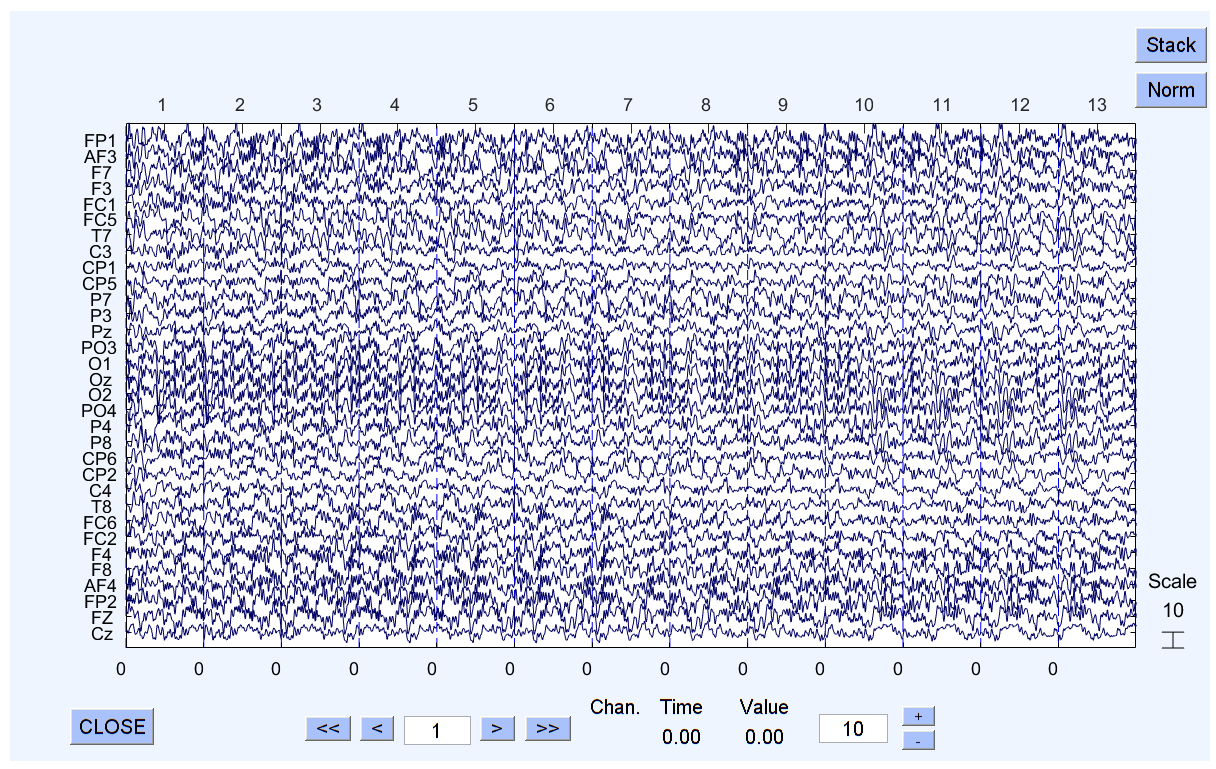

[그래프 분석] non-target 자극 이후 EEG epoch 데이터 시각화
- 크기: [채널 × 시간 × trial 수]
- eegplot()은 이 3차원 데이터를 trial 단위로 이어붙여서 2D EEG 흐름처럼 보여줌
- 현재는 non-target 자극이 발생한 시점 이후의 EEG 신호만 모아서 시각화한 상태
- 전반적 신호 상태
    - 전체적으로 파형이 일정하고 잡음이 거의 없음
    - AF3, FP1 등 일부 채널에서 살짝 느린 진폭 변화 -> 눈 움직임(EOG)일 수 있음
    - 이전 타겟 데이터와 비교할 때 큰 구조적인 차이는 없어 보임
        - 이는 ERP 분석에서 평균을 내야 분명한 차이가 드러남
- epoch 간 일관성
    - 각 epoch 간의 파형 패턴이 뚜렷한 일관성을 보이지 않음
        - 이는 non-target 자극이 사용자의 주의를 끌지 않기 때문에 ERP 반응이 뚜렷하지 않다는 걸 의미

## Run singular value decomposition (SVD) and principal component analysis (PCA)
- EEG 데이터에 대해 SVD(특이값 분해)와 PCA(주성분 분석)를 수행해서 데이터의 주요 성분(정보가 가장 많은 축)을 추출하는 과정
- 이제부터는 윈도우(에포크)를 기반으로 데이터를 처리할 수 있다.
- 즉, 특정 윈도우에 심각한 아티팩트가 포함된 경우 제외할 수 있다.

#### SVD(Singular Value Decomposition)
- 입력: 원본 데이터 행렬 [채널 x 시간]
- 출력: 데이터가 기저 벡터, 특이값
- 목적: 전체 데이터 구조 분석
- PCA는 사실상 SVD의 일부

In [ ]:
# filt_eeg: [채널 x 시간] 형태의 EEG 데이터
# svd(X): X = U * S * V'로 분해함
# U: 좌측 특이 벡터([ch x ch]) -> 공간적 패턴(채널 기반)
# S: 특이값 행렬(대각선만 존재) -> 각 성분의 세기(에너지)
# V: 우측 특이 벡터([time x time]) -> 시간적 패턴
# 에너지가 큰 특이값(S)를 갖는 성분이 데이터의 주 정보를 담고 있음
# -> EEG 신호에서 잡음 제거, 압축, 시각화 등에 활용
[U, S, V] = svd(filt_eeg, 'econ');
 % X = U * S * V'

#### PCA(Principal Component Analysis)
- 입력: 공분산 행렬([채널 x 채널])
- 출력 주성분 방향, 분산(고유값)
- 목적: 데이터 분산이 큰 방향 추출
- PCA = SVD 기반임

In [ ]:
# PCA는 데이터의 공분산 행렬을 기반으로 함
# filt_eeg' -> [시간 x 채널]로 바꿔서 채널 간 공분산을 구함
C = cov(filt_eeg');
        
# eig(C)는 공분산 행렬을 고유값 분해
# D: 고유값(각 주성분이 가진 분산)
# Vpca: 고유벡터(주성분 방향)
[Vpca, D] = eig(C);

# 고유값이 큰 순서대로 정렬 -> 가장 정보량이 많은 방향이 앞에 옴
[~, idx] = sort(diag(D), 'descend');
Vpca = Vpca(:, idx); # 고유값 큰 순서대로 정렬
D = D(idx, idx);

# 다음과 같은 ..
# 간단한 PCA 대체 함수
# MATLAB 내장 pca() 함수는 위의 과정을 자동화 함
# 출력
#   W: 주성분 방향(고유벡터)
#   Y: 주성분 점수(원 데이터를 주성분 공간으로 투영한 결과)
[W, Y] = pca(filt_eeg);

[추가 정리]: EEG에서 SVD/PCA를 왜 쓰나?
- 잡음 제거
    - 주성분 상위 몇 개만 유지하고 나머지 제거
- 시각화
    - 2D or 3D로 차원 축소하여 시각화 가능
- 특징 추출
    - 분류기 입력용 피처로 사용 가능
- 채널 간 상관 구조 파악
    - 특정 채널들의 공통 정보량 분석 가능

#### Let's draw principal component of EEG data
- PCA 또는 SVD 결과로 얻은 공간 성분(W)을 EEG 전극 위치에 대응시켜서 topographic map(두피 지도) 형식으로 시각화한 것
- 주성분 또는 특이벡터(W)의 각 성분이 공간적으로 어떤 채널에 어떻게 분포되어 있는지를 시각화
- 즉, 각 주성분(또는 특이 성분)의 scalp 분포를 보여주는 것
- 그들의 공간적 및 시간적 특성을 확인할 수 있으며, 이 정보를 통해 적절한 임계값을 가진 신호 공간과 잡음 공간을 선택할 수 있다.

In [ ]:
figure,
for i=1:size(filt_eeg, 1)-1 # for i = 1:채널 수 - 1	EEG 채널 수만큼 반복 (예: 32채널이면 31번 반복)
    subplot(6,6,i); # 6x6 격자 중 i번째 칸에 plot (최대 36개의 topomap 표시 가능)
    topoplot(W(i, :), ch_locs); # i번째 성분의 공간적 분포를 EEG 채널 위치에 맞춰 시각화
end

# topoplot() 함수란?
# EEGLAB 함수로 EEG 전극 위치에 따라 값을 시각화
# 입력
#   첫 번째 인자: 채널별 스칼라 값 (예: 주성분 가중치)
#   두 번쩨 인자: 채널 위치 정보 (ch_locs, 보통 cur_eeg.chanlocs)
# W(i,:): i번째 주성분(또는 특이벡터)의 각 채널에 대한 가중치
# 이걸 scalp 위에 색상으로 표현하면, -> 어떤 채널에서 해당 성분이 강하게 작용하는지 시각적으로 파악 가능

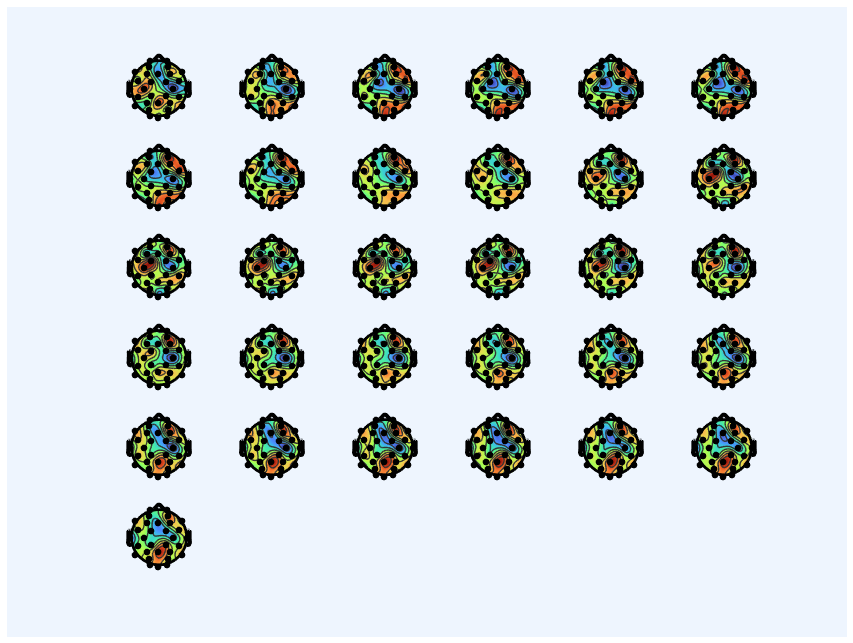

In [ ]:
# PCA 또는 SVD 이후의 결과(Y)를 eegplot()으로 시각화
# 인자:
#   Y: PCA 또는 SVD 후의 성분 점수(Projected data)
#   'srate', srate: 샘플링 주파수
#   'eloc_file', ch_locs: 채널 위치 정보(좌측에 채널 이름 표시됨)
eegplot(Y, 'srate', srate, 'eloc_file', ch_locs);

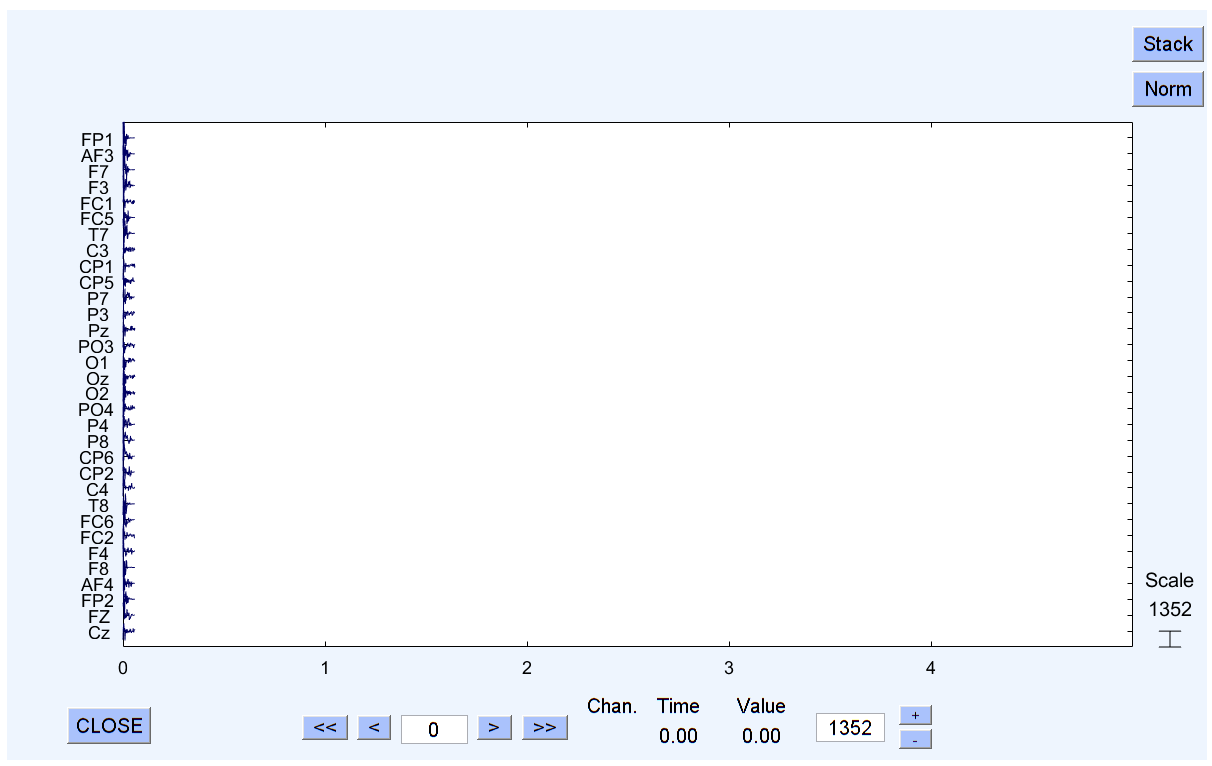

#### Selecting a few components
- SVD를 통해 EEG 데이터를 압축하고, 그 중 상위 5개의 성분만으로 원래 데이터를 재구성(reconstruction)해서 정보 보존 정도를 시각적으로 확인하는 작업

In [ ]:
# X_reduced는 5개의 구성 요소로 재귀성되므로 원본 데이터와 비교
# SVD 기반 차원 축소 -> 데이터 재구성
# 원래 SVD 분해: filt_eeg: U * S * V'
# 그런데, 여기서는 상위 k = 5개의 성분만 사용해서 데이터 근사
#   X_reduced = U_k * S_k * V'_k
# 이렇게 되면:
#   데이터의 주요 정보(에너지)를 보존하면서
#   잡음이나 불필요한 성분을 제거한 형태의 데이터 생성
k = 5;
X_reduced = U(:,1:k) * S(1:k,1:k) * V(:,1:k)';

In [ ]:
# 그들은 비슷해 보이며, 이는 현재 기간을 설명할 수 있는 5가지 강력한 구성 요소를 나타냄
# 재구성한 데이터 시각화
# eegplot()을 이용해서 두 신호를 비교 시각화
#   filt_eeg: 원본 핑터링된 EEG
#   X_reduced: 상위 5개 성분으로 재구성된 EEG
# 파란색: 원본
# 빨간색: 재구성된 신호
eegplot(filt_eeg, 'srate', srate, 'eloc_file', ch_locs, 'data2', X_reduced);

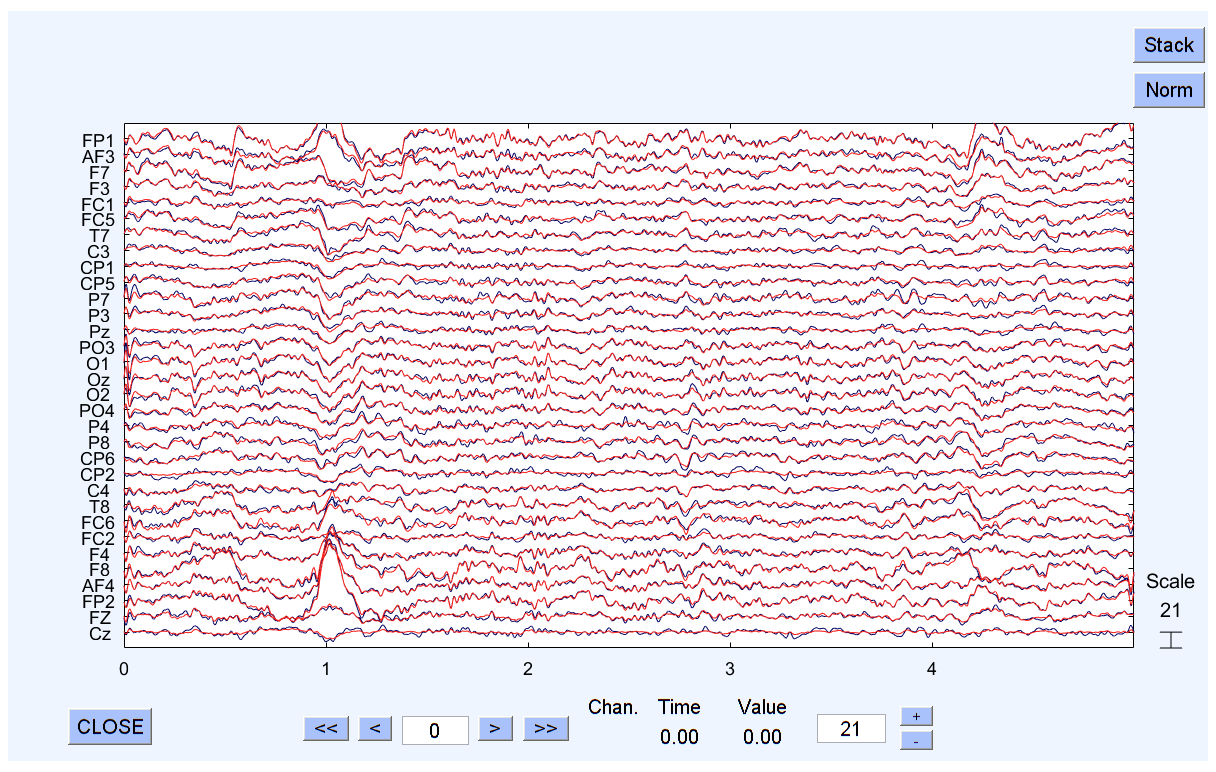

[그래프 분석]: SVD 기반 차원 축소 후 복원된 EEG 데이터(X_reduced)를 원본 필터링 EEG(filt_eeg)와 비교한 그래프
- 파란색: 원본 EEG(filt_eeg)
- 빨간색: SVD 후 상위 5개 성분으로 복원된 EEG(X_reduced)
- 유사성
    - 전체적으로 두 곡선이 거의 겹쳐 있음
        - 상위 5개 성분만으로도 원본의 주요 구조를 잘 재현하고 있다는 의미
        - 시간축과 채널 전반에 걸쳐 큰 차이가 없음 -> 정보 손실이 거의 없음
- 차이점
    - 특정 구간(예: 약 1초 부근)에서 약간의 차이가 보임
        - AF4, FP2, FC2, F4 근처
        - 이 영역은 주로 눈 깜빡임, 이마 근전도 등 아티팩트가 들어오는 부분
        - 즉, 상위 성분들이 주요 정보는 유지하면서 잡음은 일부 제거한 것일 수 있음
- 스케일과 진폭
    - 진폭 범위(Scale)는 약 ±21μV로 적당함
    - ERP 분석에서 흔히 보는 수준이며, 비정상적으로 과장되거나 축소되지 않음
- 이 결과는 SVD 기반 차원 축소가 EEG 신호에서 주요 정보를 효율적으로 유지하면서, 불필요한 잡음을 줄이는 데 효과적이라는 걸 보여줌
- 특히 ERP 분석이나 머신러닝 입력 특성 추출 시, 성분 수 제한(SVD, PCA 5~10개 정도)은 좋은 방법이 될 수 있음

[ICA vs PCA/SVD]
- 분해 기준
    - PCA/SVD: 에너지(분산)
    - ICA: 통계적 독립성
- 목적
    - PCA/SVD: 주요 정보 추출
    - ICA: 잡음 분리 제거
- 성분 해석
    - PCA/SVD: 성분이 혼합됨
    - ICA: 해석 가능성 높음(눈 깜빡임, 근육 등)
- 제거 방식
    - PCA/SVD: 성분 일부만 사용
    - ICA: 성분 중 일부만 삭제하고 나머지 보존

#### Independent Component Analysis (ICA)
- EEG 데이터에서 ICA(독립 성분 분석)를 수행해서 생리적 아티팩트(눈 깜빡임, 안구 움직임 등)를 제거하려는 목적
- SVD/PCA와 달리, ICA는 신호 공간 전체를 유지하면서도 잡음 성분만 골라서 제거 가능
- 반면, 뇌파 데이터의 노이즈 구성 요소만 거부
- ICA로 잡음 제거는 어떻게 하나?
    - 1. runica()로 성분 분해
    - 2. 각 성분을 topoplot/time-series/spectrum으로 시각화해서 해석
    - 3. 잡음 성분(눈 움직임, 심장박동, 근육 등)을 선택해서 제거
    - 4. 나머지 성분만으로 inverse ICA로 신호 복원


In [ ]:
# ICA를 통해 EEG 신호를 서로 통계적으로 독립적인 성분들로 분해한 뒤, 노이즈(잡음) 성분만 제거하고 유효한 뇌파 성분만 남기기 위한 전처리 단계

# runica() 함수
#   입력: filt_eeg([채널 x 시간])
#   출력:
#       ica.weights: ICA 가중치 행렬(W)
#       ica.sphere: 전처리된 구형화(sphering) 행렬
ica = [];
[ica.weights, ica.sphere] = runica(filt_eeg); % you can apply various ica (this function is from EEGLAB and infomax ICA)

In [ ]:
# ICA 성분을 계산하고, 시각화하여 해석 가능한 상태로 표현
# runica()로 분해한 후:
#   1. 독립 성분(ica.ics)을 계산
#   2. 성분 시계열을 eegplot()으로 시각화
#   3. 각 성분의 공간 분포(topomap)를 그려서 어떤 잡음인지 해석 가능하게 만듦

# ICA 수학적 구성
# ICA 변환 행렬(unmixing matrix)
# EEG 원본 데이터 X에 대해:
#   ica.ics = W * S * X = ica.unmix * X -> 독립 성분(Independent Components) 추출
ica.unmix = ica.weights * ica.sphere;

# ICA 변환 행렬의 역행렬
# 흔히 mixing matrix 또는 A hat
# 각 성분이 어떤 채널에 얼마만큼 섞여 있는지를 나타냄
# topoplot에 쓰일 핵심 요소
ica.winv = inv(ica.unmix); % A hat (weight inverse)

# 최종적으로 계산된 독립 성분들
# 크기: [components × time]
# 각 행이 하나의 ICA 성분, 각 열이 시간축
ica.ics = ica.unmix * filt_eeg;
% Estimated sources: ica.ics = ica.weights * ica.sphere * X


# ICA 성분 시각화
# 1) 시간축 시각화(신호 파형)
# 각 ICA 성분의 시계열을 확인 가능
# 눈 깜빡임, 안구 움직임, 심장박동, 근전도 등의 전형적인 잡음 성분 패턴이 드러남
# 흔한 특징:
#   눈 깜빡임 -> 큰 진폭, 느리고 주기적
#   근전도 -> 고주파 진동
#   심장박동 -> 주기적 sharp peak
eegplot(ica.ics, 'srate', srate, 'winlength', 15);

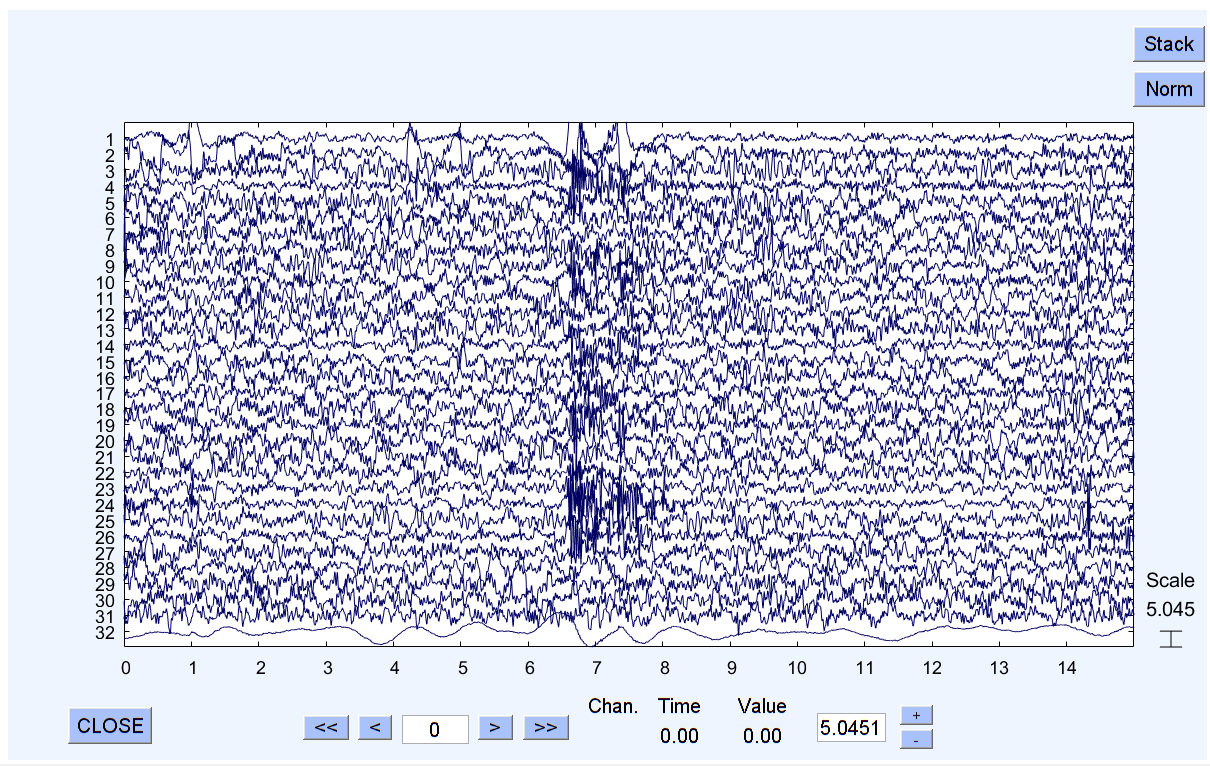

In [ ]:
# 2) 공간 분포 시각화 (topoplot)
# ica.winv(:,i): i번째 ICA 성분의 scalp 분포 (mixing 가중치)
# EEG 전극 위치(ch_locs)에 기반하여 색으로 표현
# 총 32채널이면 -> 6×6 그리드에 32개 topomap 출력
figure,
for i=1:size(filt_eeg, 1)
    subplot(6,6,i);
    topoplot(ica.winv(:,i),ch_locs); colorbar;...
        title(strcat('Components ', num2str(i))); colormap('jet')
end

In [ ]:
# EEG 데이터와 ICA 성분의 주파수 도메인 특성을 비교 분석하기 위한 시각화 코드
# filt_eeg: 채널 × 시간 형태의 원본 EEG 신호
# spectopo(...): 각 채널의 파워 스펙트럼을 계산하고 평균해서 보여줌
# overlap = srate/2: FFT 윈도우를 50% 중첩하여 스무딩
# xlim([0 70]): 0~70Hz 주파수 범위만 보기
# ylim([-20 40]): 파워 dB 스케일 범위 제한
figure,
subplot(2,1,1); spectopo(filt_eeg, 0, srate, 'overlap', srate/2);

xlim([0 70]); ylim([-20 40]); title('raw EEG spectral power -- spectopo()');

subplot(2,1,2); spectopo(ica.ics, 0, srate, 'overlap', srate/2);

xlim([0 70]); ylim([-20 40]); title('Components spectral power -- spectopo()');

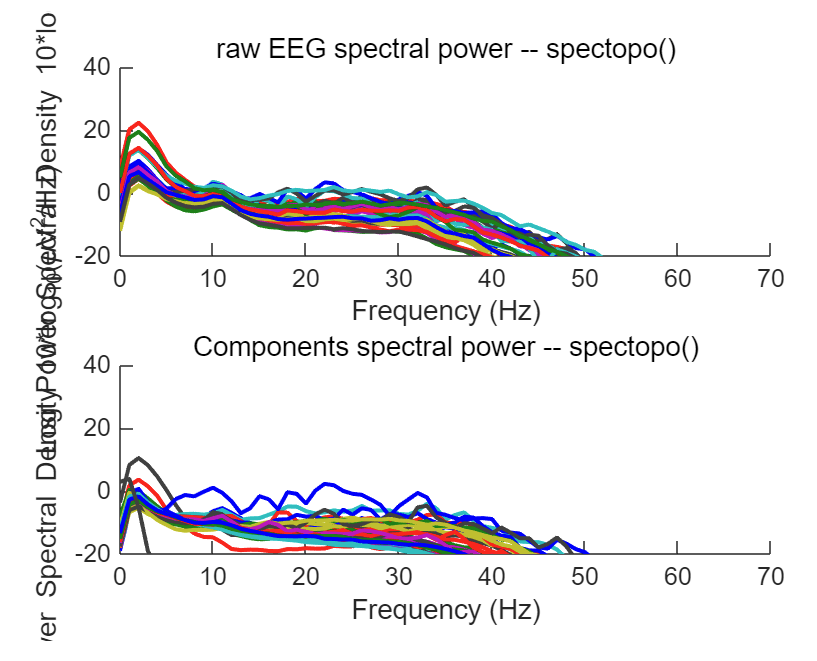

[그래프 분석]: EEG 데이터와 ICA 성분 각각의 주파수 파워 분포(Power Spectral Density, PSD)를 spectopo()로 시각화한 결과
- 위쪽은 원본 EEG 채널별 PSD
- 아래쪽은 ICA로 분해된 성분별 PSD
- 위쪽 그래프 분석 (raw EEG)
    - 0~10 Hz 구간에서 전체적으로 파워가 높음
        - 이는 저주파 활동이 많다는 뜻. 일반적인 **눈 깜빡임, EOG, 델타파(0.5~4Hz)**가 포함됐을 가능성
    -10~30 Hz 구간에 완만한 파워 분포
        - 알파파(8~12Hz), 베타파(13~30Hz) 등이 정상적으로 존재
    - 40~50 Hz 이후는 대부분 파워가 급감
        - 필터가 적용된 것으로 보이며, 노이즈 차단이 잘 된 상태
    - 해석
        - 원본 EEG는 전반적으로 정상적인 스펙트럼 특성을 보임
        - 일부 채널은 0~5 Hz에서 파워가 과도함 → EOG(눈 움직임) 가능성 있음
- 아래쪽 그래프 분석 (ICA components)
    - 일부 성분에서만 특정 주파수 대역의 파워가 매우 높음
        - 예: 5Hz 근처에서 튀는 파형 → 특정 성분에 눈 깜빡임이 고립되었을 가능성
    - 20~40Hz에서 넓게 퍼진 파워 → 근전도(EMG) 성분일 가능성
    - 대부분 성분은 고르게 분산되어 있고, 원본보다 전반적으로 파워가 낮아짐
    - 해석
        - ICA 분해가 잘 되었고, 잡음 성분들이 특정 성분에 집중되었음
        - 아래쪽 그래프에서 튀는 성분은 아티팩트 성분 후보
        - 그 외 성분은 신경 신호일 가능성 높음 → 유지할 수 있음

#### Reject noise components(노이즈 구성 요소 거부)
- 데이터를 재구성할 때 필요한 최소한의 노이즈 구성 요소를 거부할 수 있도록 노이즈 프로파일을 알고 있다.
- 사용자가 선택한 ICA 성분을 제거한 뒤, 나머지 성분만으로 EEG 데이터를 복원(cleaning)하는 과정
- 아트팩트(눈 깜빡임, 근전도 등)을 제거하기 위한 전형적인 ICA 응용
- ICA 분해 후 특정 잡음 성분만 제거하고,
나머지 성분을 조합해서 깨끗한 EEG(clean_data)를 재구성하는 과정

In [ ]:
# 사용자에게 제거할 ICA 성분 번호를 입력 받음
reject_set = input('Please type \nEEG ICA componets that you want to reject: ', 's');

# 입력 문자열을 숫자 배열로 변환
# 결과: [1 3 5] 등 -> 제거할 ICA 성분의 index
reject_idx = str2num(reject_set);

# ica.winv: ICA의 mixing matrix (성분 → 채널로 되돌리는 변환 행렬)
ica.mask_winv = ica.winv;

# 위 코드는 선택한 성분의 영향력만 0으로 만드는 마스크 처리
#   -> 즉, 해당 ICA 성분은 완전히 제거됨
ica.mask_winv(:, reject_idx) = 0;

# 남아 있는 ICA 성분들만 이용해 EEG 복원
clean_data = ica.mask_winv * ica.ics;

# 결과:
#   잡음 성분 제거된 EEG (clean_data)
#   크기: [채널 × 시간]
#   이걸 다시 eegplot()이나 spectopo()로 확인 가능

In [ ]:
# filt_eeg: 원본 EEG 데이터 (잡음 제거 전)
# 'data2', clean_data: 비교 대상 데이터 (잡음 제거 후)
eegplot(filt_eeg, 'data2', clean_data, 'srate', srate, 'winlength', 10, ...
    'title', 'Black = channel before rejection; red = after rejection -- eegplot()', ...
    'eloc_file', ch_locs);

In [ ]:
figure,
subplot(2,1,1);
spectopo(filt_eeg, 0, srate); xlim([0 40]);
title('Before component rejection -- spectopo()'); pbaspect([1, 1, 1]);

subplot(2,1,2);
spectopo(clean_data, 0, srate); xlim([0 40]);
title('After component rejection -- spectopo()'); pbaspect([1, 1, 1]);

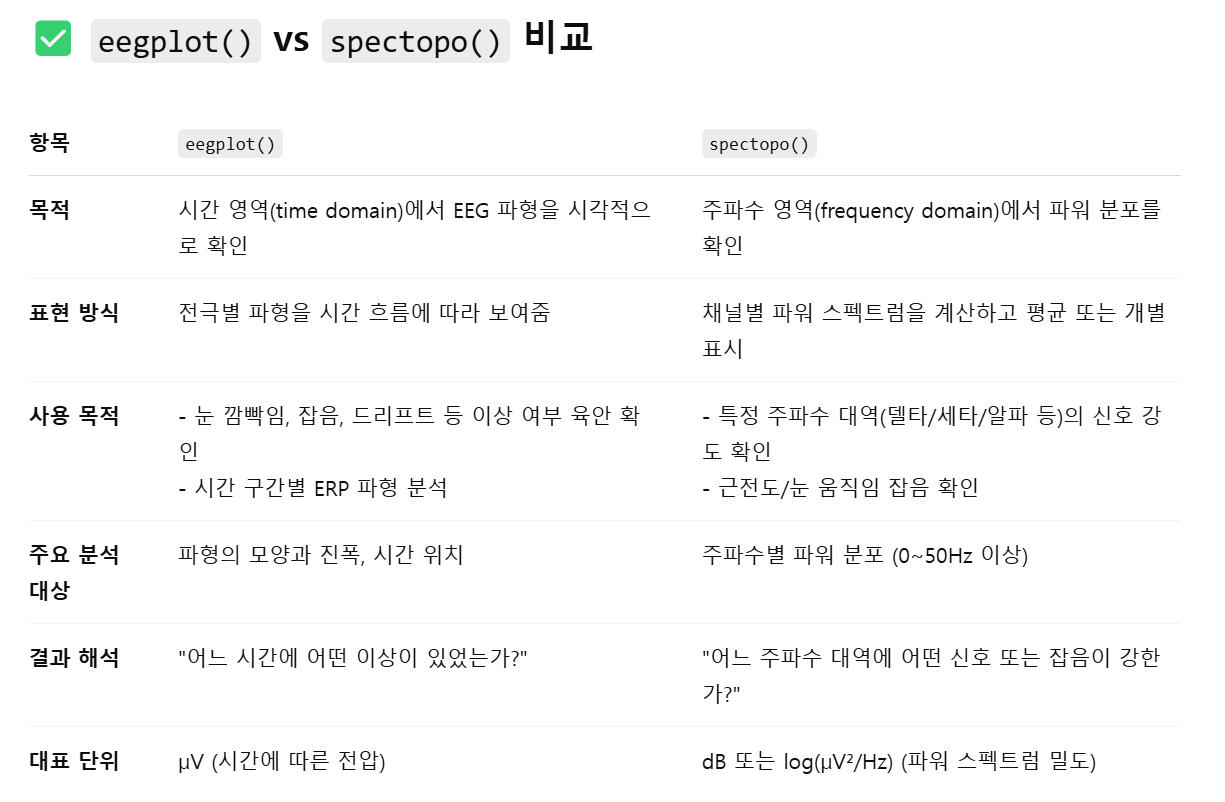

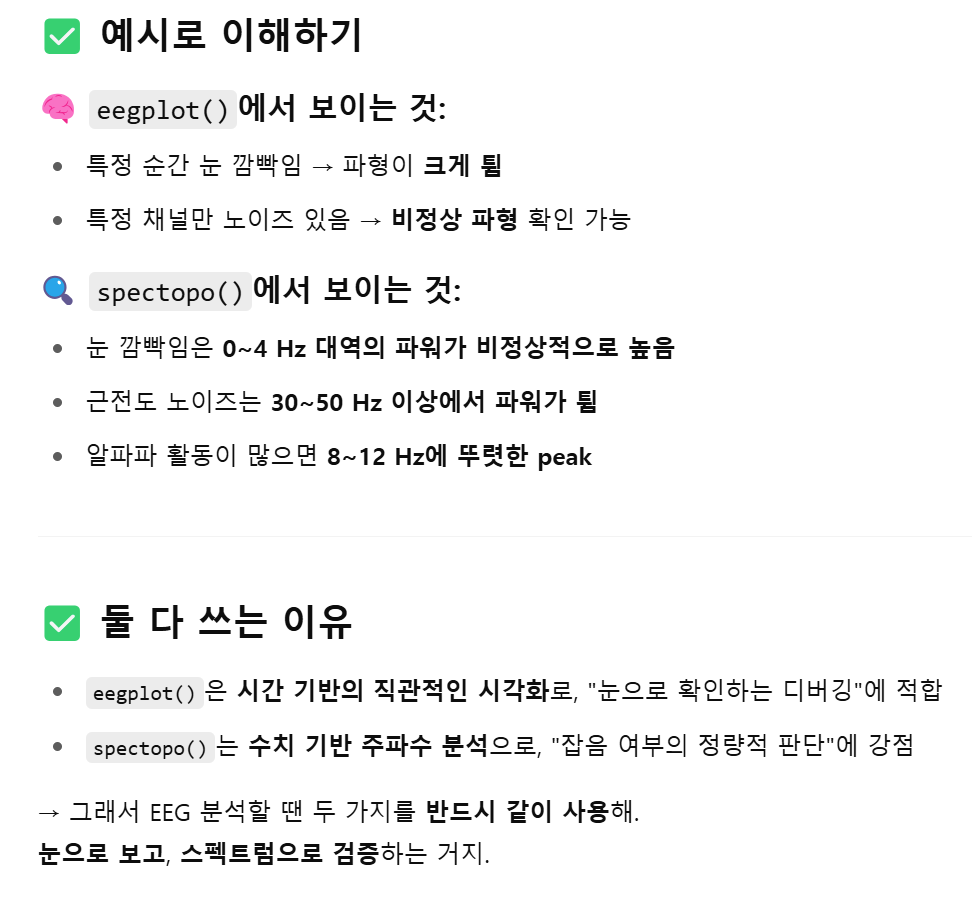

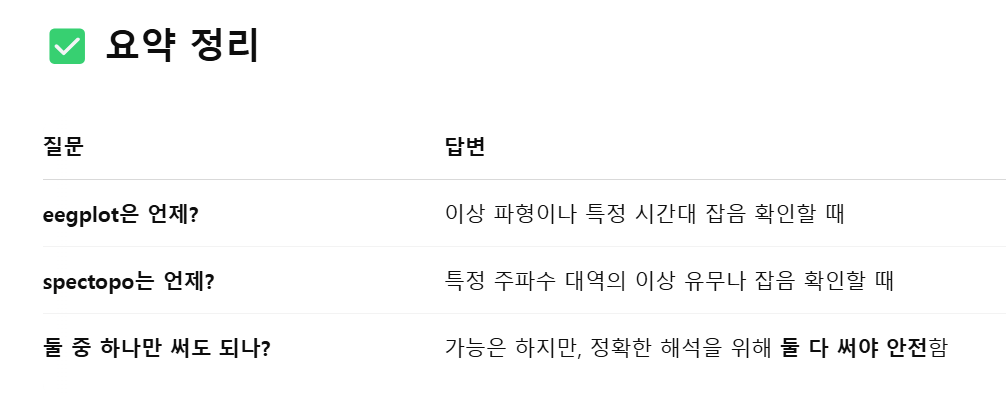